# Beiwe Homestay Data from GPS Traces
Peter provided the homestay data from the GPS traces and this notebook just helps take a look at it and process it for later use.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [2]:
import sys
import os
sys.path.append('../')

from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Import
We have the files stored in the `interim` directory so we can import them by participant.

In [3]:
data_dir = "../"
data = pd.DataFrame()
for pt in os.listdir(f"{data_dir}data/interim/utx000-beiwe-homestay/"):
    temp = pd.read_csv(f"{data_dir}data/interim/utx000-beiwe-homestay/{pt}",parse_dates=["start","end"],infer_datetime_format=True)
    temp = temp.iloc[:,1:]
    temp["beiwe"] = pt.split("_")[1].split(".")[0]
    data = data.append(temp)

In [4]:
data.head()

,home.lat,home.long,start,end,nth.stay,beiwe
0,30.290428,-97.750645,2020-07-13 20:30:46,2020-07-14 05:08:52,1,i31pt4b4
1,30.290428,-97.750645,2020-07-14 05:48:53,2020-07-14 06:40:53,2,i31pt4b4
2,30.290428,-97.750645,2020-07-14 07:08:57,2020-07-14 07:39:15,3,i31pt4b4
3,30.290428,-97.750645,2020-07-14 08:14:59,2020-07-14 09:32:53,4,i31pt4b4
4,30.290428,-97.750645,2020-07-14 20:16:46,2020-07-15 08:36:58,5,i31pt4b4


# Inspection
We can look at a few derivatives.

In [5]:
data["t"] = (data["end"] - data["start"]).dt.total_seconds()

## Comparing Lat/Long from Beiwe to Provided Address

In [45]:
# Importing the data
raw_info = pd.read_excel("../data/raw/utx000/admin/id_crossover.xlsx",sheet_name="beacon")
info = raw_info[["beiwe","lat","long","lat2","long2"]]
# filtering dataset
add = data.groupby("beiwe").median().reset_index()
add.rename({"home.lat":"lat","home.long":"long"},axis="columns",inplace=True)
# merging
merged = add.merge(right=info,on="beiwe",suffixes=["_peter","_hagen"])

In [46]:
def plot_bar(df,lat1,lat2,long1,long2):
    """"""
    lat_diff = abs(df[lat1] - df[lat2])
    long_diff = abs(df[long1] - df[long2])

    x = np.arange(len(df))
    width = 0.4

    fig, ax = plt.subplots(figsize=(16,6))
    rects1 = ax.bar(x - width/2, lat_diff, width, label='Lat', color="cornflowerblue", edgecolor="black")
    rects2 = ax.bar(x + width/2, long_diff, width, label='Long', color="seagreen", edgecolor="black")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Absolute Difference in Coordinates')
    ax.set_xticks(x)
    ax.set_xticklabels(df["beiwe"],rotation=-30,ha="left")
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    ax.legend()

    plt.show()


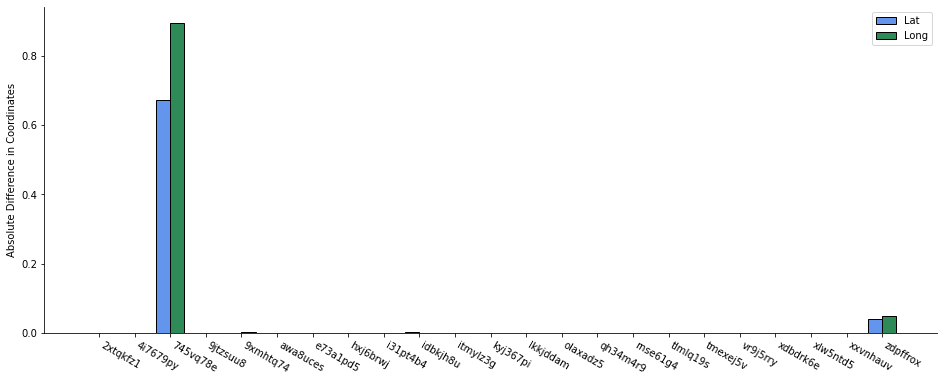

In [47]:
plot_bar(merged,"lat_hagen","lat_peter","long_hagen","long_peter")

## Getting Move-Out Dates

In [40]:
move = raw_info[["beiwe","original_end","original_move"]]
move.fillna(datetime(2020,9,14),inplace=True)
move["move"] = [d if d != e else np.nan for d, e in zip(move["original_move"],move["original_end"]) ]
move.drop(["original_end","original_move"],axis="columns",inplace=True)
move.to_csv("../data/raw/utx000/admin/move_dates-ux_s20.csv",index=False)

# Saving

In [29]:
data.to_csv("../data/processed/beiwe-homestay-ux_s20.csv")